In [9]:
import os
import nltk 
import gensim
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import BatchNormalization
#from keras.layers import Sequential
from keras.layers import LSTM, BatchNormalization, Dropout, Dense
from PIL import Image, ImageFile
!pip install keras_preprocessing
from keras_preprocessing.sequence import pad_sequences
adam = keras.optimizers.Adam(lr=1e-3) # Optimizer Adam
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, concatenate
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input  
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Read the dataset
#outputPath =  "dataset/output"
#word2vec_path='amharic-word2vec-300D.gz'
#dataset_path= 'preprocessed_multimodal_dataset_last_all_840.xlsx'
#img_dir = "dataset/images/"
#class_weight = {1: 1.4,
#               0: 1.0}
outputPath =  "/content/drive/MyDrive/dataset_copy/"
word2vec_path='/content/drive/MyDrive/amharic-word2vec-300D.gz'
dataset_path= '/content/drive/MyDrive/dataset_copy/preprocessed_multimodal_dataset_last_all_840.xlsx'
img_dir = "/content/drive/MyDrive/dataset_copy/IMG/"
class_weight = {1: 1.4,
                0: 1.0}     

In [11]:
dataset = pd.read_excel(dataset_path)

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [12]:
label_map = {'normal speech': 0, 'hate speech': 1}
dataset["Lable"] = dataset["Lable"].map(label_map)

In [13]:
# splitting dataset into traing, test and validation
df=dataset
X_train, X_test, y_train, y_test = train_test_split(df[['image', 'text']], df['Lable'], test_size=0.2, random_state=42)

In [14]:
# process the whole observation into single list
train_text_list= [str(d).split() for d in X_train['text'].tolist()]
test_text_list =  [str(d).split() for d in X_test['text'].tolist()] 

# process the whole observation into single list
y_train= [str(d).split() for d in y_train.tolist()]
y_test =  [str(d).split() for d in y_test.tolist()] 

In [8]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=False) 

KeyboardInterrupt: ignored

In [ ]:
word2vec_model

In [ ]:
# Tokenize the sentences and encode them into sequence of integers
max_length=25
DIM = 300
maxlen = 25

vocab_size = 7582
tokenizer_train = Tokenizer()
tokenizer_train = Tokenizer(num_words=vocab_size, oov_token="unk")
tokenizer_train.fit_on_texts(train_text_list)
train_sequence = np.array(tokenizer_train.texts_to_sequences(train_text_list), dtype=object)
x_train = pad_sequences(train_sequence, padding='post', maxlen=max_length)

tokenizer_test = Tokenizer()
tokenizer_test = Tokenizer(num_words=vocab_size, oov_token="unk")
tokenizer_test.fit_on_texts(test_text_list)
test_sequence = np.array(tokenizer_test.texts_to_sequences(test_text_list), dtype=object)
x_test = pad_sequences(test_sequence, padding='post', maxlen=max_length)

In [ ]:
from keras.utils import to_categorical

x_train = x_train.astype(np.float32)

y_train = pd.to_numeric(y_train, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')


y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)



#y_test = y_test.values.reshape(-1,1)
#y_train = y_train.values.reshape(-1,1)
y_train = to_categorical(y_train,2)
y_test = to_categorical(y_test,2)

In [ ]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]

In [ ]:
## image path 
img_path=[]
def create_img_path(DF, Col_name, img_dir):
    formats = ['.jpg', '.PNG', '.JPG', '.png', '.JPEG', '.GIF', '.PSD', '.jpeg']
    img_path=[]
    for file_name in DF['image']:
        for fmt in formats:
            if str(file_name) + fmt in os.listdir(img_dir):
                img_path.append(img_dir + str(file_name) + fmt)
                break
        else:
            raise ValueError(f'Could not find image {file_name} in {img_dir}')
    return img_path

# Creating train, test and validation image path
img_paths = create_img_path(df, 'image', img_dir)

## start

In [ ]:
from keras.applications.vgg16 import VGG16
# Load pre-trained VGG16 model for image feature extraction
vgg16_model = VGG16(weights='imagenet')

# Remove last output layer of VGG16 model
image_feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.layers[-2].output)



553467096/553467096 [==============================] - 4s 0us/step


In [ ]:

# Extract image features and store in a list
image_features = []
for path in img_paths:
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = image_feature_extractor.predict(x)
  image_features.append(features)
# Convert image features list to numpy array
image_features = np.array(image_features)

# Reshape image_features to (382, 4096)
image_features = np.squeeze(image_features)

In [ ]:
text_features = df_x
text_features = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim,weights=[embedding_matrix], trainable=False)(text_features)
text_features = keras.layers.Flatten()(text_features)
# Reshape text_features to have an additional dimension
#text_features = np.expand_dims(np.expand_dims(text_features, axis=1), axis=1)
# Tile the text_features to match the shape of image_features
#text_features_tiled = np.tile(text_features, (1, 7, 7, 1)


In [ ]:
# Combine image and textual features
X = np.concatenate((image_features, text_features), axis=1)

In [ ]:
print(text_features.shape)
print(image_features.shape)
print(X.shape)
print(df_y.shape)

(478, 7500)
(478, 4096)
(478, 11596)
(478, 2)


In [ ]:
# Split data into training and testing sets (70% training, 30% testing and validation)
X_train, X_test, y_train, y_test = train_test_split(X, df_y, test_size=0.30, random_state=42)

# Split training data into training and validation sets (15% testing, 15% validation)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=42)


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)


(334, 11596)
(72, 11596)
(72, 11596)
(334, 2)
(72, 2)
(72, 2)


## LSTM

In [ ]:
# Define LSTM model
LSTM_model = Sequential()
LSTM_model.add(LSTM(units=64, input_shape=(X.shape[1], 1), return_sequences=True))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(LSTM(units=64, return_sequences=True))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(LSTM(units=64))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(units=32))
LSTM_model.add(Dense(units=2, activation='softmax'))

In [ ]:
# Compile model
LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
# Fit model on data with validation set
LSTM_history = LSTM_model.fit(X_train, y_train, epochs=3, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/3
21/21 [==============================] - 1141s 54s/step - loss: 0.6136 - accuracy: 0.7814 - val_loss: 0.4736 - val_accuracy: 0.8333
Epoch 2/3
21/21 [==============================] - 1149s 55s/step - loss: 0.5220 - accuracy: 0.7934 - val_loss: 0.4526 - val_accuracy: 0.8333
Epoch 3/3
21/21 [==============================] - 1135s 54s/step - loss: 0.5167 - accuracy: 0.7934 - val_loss: 0.4579 - val_accuracy: 0.8333


In [ ]:
# Saving text model
LSTM_model.save(outputPath+'before_LSTM_model.h5')

3/3 - 19s - loss: 0.5299 - accuracy: 0.7778 - 19s/epoch - 6s/step
Test accuracy: 0.7777777910232544


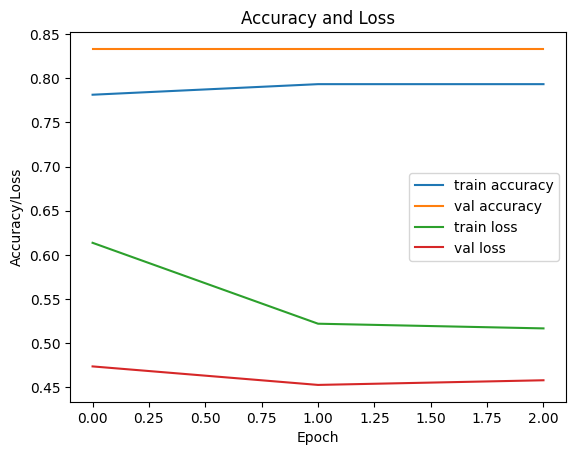

In [ ]:
# Evaluate model on test data
test_loss, test_acc = LSTM_model.evaluate(X_test, y_test, verbose=2)
print("Test accuracy:", test_acc)

# Graph Accuracy and Loss
plt.plot(LSTM_history.history['accuracy'], label='train accuracy')
plt.plot(LSTM_history.history['val_accuracy'], label='val accuracy')
plt.plot(LSTM_history.history['loss'], label='train loss')
plt.plot(LSTM_history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.show()

## BiLSTM

Epoch 1/3
11/11 [==============================] - 696s 62s/step - loss: 0.5671 - accuracy: 0.7515 - val_loss: 0.4591 - val_accuracy: 0.8333
Epoch 2/3
11/11 [==============================] - 681s 62s/step - loss: 0.5179 - accuracy: 0.7934 - val_loss: 0.4620 - val_accuracy: 0.8333
Epoch 3/3
11/11 [==============================] - 683s 62s/step - loss: 0.5052 - accuracy: 0.7934 - val_loss: 0.4557 - val_accuracy: 0.8333


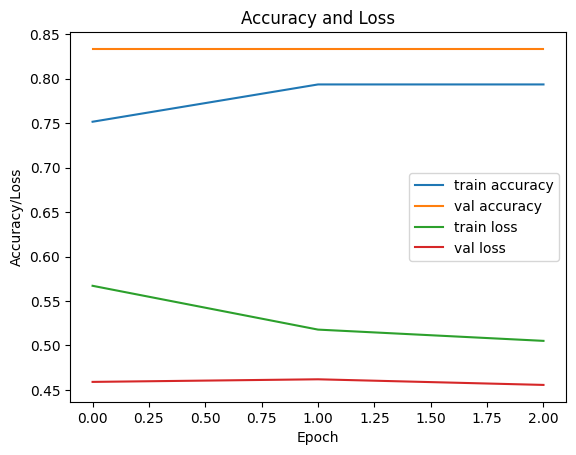

In [ ]:
from keras.layers import Bidirectional
from keras.layers import Bidirectional, Reshape

# Define BiLSTM model
BiLSTM_model = Sequential()
BiLSTM_model.add(Reshape(target_shape=(X_train.shape[1], 1), input_shape=(X_train.shape[1],)))
BiLSTM_model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
BiLSTM_model.add(Dropout(0.2))
BiLSTM_model.add(Bidirectional(LSTM(units=64)))
BiLSTM_model.add(Dropout(0.2))
BiLSTM_model.add(Dense(units=32))
BiLSTM_model.add(Dense(units=2, activation='softmax'))

# Compile model
BiLSTM_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit model on data with validation set
BiLSTM_history = BiLSTM_model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_val, y_val))

# Graph Accuracy and Loss
plt.plot(BiLSTM_history.history['accuracy'], label='train accuracy')
plt.plot(BiLSTM_history.history['val_accuracy'], label='val accuracy')
plt.plot(BiLSTM_history.history['loss'], label='train loss')
plt.plot(BiLSTM_history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.show()

In [ ]:
# Fit model on data with validation set
BiLSTM_history = BiLSTM_model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
# Saving text model
BiLSTM_model.save(outputPath+'before_BiLSTM_model.h5')

In [ ]:
# Evaluate model on test data
#test_loss, test_acc = LSTM_model.evaluate(X_test, y_test, verbose=2)
#print("Test accuracy:", test_acc)

# Graph Accuracy and Loss
plt.plot(BiLSTM_history.history['accuracy'], label='train accuracy')
plt.plot(BiLSTM_history.history['val_accuracy'], label='val accuracy')
plt.plot(BiLSTM_history.history['loss'], label='train loss')
plt.plot(BiLSTM_history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = BiLSTM_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test[:,1], y_pred, labels=[0, 1])
print(cm)



## CNN

In [ ]:
from keras.layers import Reshape
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten



In [ ]:
# Define model
cnn_model = Sequential()
cnn_model.add(Reshape(target_shape=(X_train.shape[1], 1), input_shape=(X_train.shape[1],)))
cnn_model.add(Conv1D(filters=64,kernel_size=3,padding='valid',activation='relu'))
cnn_model.add(Conv1D(filters=64,kernel_size=3,padding='valid',activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(filters=64,kernel_size=3,padding='valid',activation='relu'))
cnn_model.add(Conv1D(filters=64,kernel_size=3,padding='valid',activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=32))
cnn_model.add(Dense(units=2, activation='softmax'))

# Compile model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit model on data with validation set
cnn_history = cnn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
# Saving text model
cnn_model.save(outputPath+'before_cnn_model.h5')

In [ ]:
# Graph Accuracy and Loss
plt.plot(cnn_history.history['accuracy'], label='train accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='val accuracy')
plt.plot(cnn_history.history['loss'], label='train loss')
plt.plot(cnn_history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.show()

## end

Flask app:

```python
from flask import Flask, render_template, request
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import pandas as pd
import numpy as np
import cv2
import pytesseract

app = Flask(__name__)
model = load_model('hate_speech.h5')
image_feature_extractor = VGG16(weights='imagenet')
vocab_size = 5000 # Example only
embedding_dim = 100 # Example only
embedding_matrix = ... # Example only
df_x = pd.read_csv('memes_text.csv', usecols=['text'])

def preprocess_image(img_path):
    # Preprocess image before extracting features
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_text(image_path):
    # Extract text from the meme image using Tesseract OCR
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 3)
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY,11,30)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilate = cv2.dilate(thresh, kernel, iterations=1)
    config = ('-l eng --oem 1 --psm 6')
    text = pytesseract.image_to_string(dilate, config=config)
    return text

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    # Predict the class of the uploaded meme
    img = request.files['image']
    img_path = "static/" + img.filename
    img.save(img_path)

    text = extract_text(img_path)
    x_img = preprocess_image(img_path)
    features = image_feature_extractor.predict(x_img)
    features = np.squeeze(features)

    text_features = df_x
    text_features = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim,weights=[embedding_matrix], trainable=False)(text_features)
    text_features = keras.layers.Flatten()(text_features)

    X = np.concatenate((features, text_features), axis=1)
    y_pred = model.predict(X)

    if y_pred > 0.5:
        result = "This is hate speech meme"
    else:
        result = "This is not hate speech meme"

    return render_template('index.html', prediction=result, image=img_path, text=text)

if __name__ == '__main__':
    app.run(debug=True)
```

HTML code:

```html
<!DOCTYPE html>
<html>
<head>
    <title>Meme Hate Speech Detector</title>
</head>
<body>
    <h1>Meme Hate Speech Detector</h1>
    <form method="POST" action="/predict" enctype="multipart/form-data">
        <input type="file" name="image" accept="image/*" required>
        <input type="submit" value="Predict">
    </form>

    {% if prediction %}
        <p>{{ prediction }}</p>
    {% endif %}

    {% if image %}
        <img src="{{ image }}" width="400">
    {% endif %}

    {% if text %}
        <p>{{ text }}</p>
    {% endif %}
</body>
</html>